# (0) RecSys 기초 대회 미션1

Book recommondation Dataset EDA

탐색적 데이터 분석이라고 불리는 EDA (Exploratory Data Analysis)는 수집한 데이터를 다양한 각도에서 관찰하고 이해하는 과정을 말합니다.

기본적으로 데이터를 잘 파악해야 새로운 인사이트를 발견하고, 이를 분석에 활용하여 더 높은 성능을 내기 위한 다양한 실험을 해볼 수 있습니다.

본 미션을 통해 추후 모델의 성능 향상에 도움이 될만한 새로운 아이디어를 떠올릴 수 있는 시간을 갖게 될 것입니다.


# (1) 데이터

RecSys 기초 대회 강의에서는Book Crossing 데이터를 사용하여, 모든 실습 및 미션, 대회를 진행합니다. [Kaggle Book-Crossing](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset) 을 출처로 하며, 데이터는 재구성되어 제공되었습니다. 해당 데이터는 CC0: Public Domain 라이센스임을 밝힙니다.



본 대회에 활용되는 데이터는 총 3개의 파일입니다.

user : 사용자 정보를 담고 있는 데이터 파일

ratings: 책의 등급을 1-10으로 표현한 데이터 파일

books: 책과 관련된 정보를 표현한 데이터 파일

먼저 세 파일을 로드하는 과정을 수행하겠습니다.

In [2]:
# !pip install -q dython
# !pip install -q 'matplotlib==3.5.3'
# !pip install -q 'seaborn==0.11.2'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17Zbpx_Yn0ggLFVeijUalcnOUt5mCHeEH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17Zbpx_Yn0ggLFVeijUalcnOUt5mCHeEH" -O users.csv && rm -rf ~/cookies.txt
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JIxWPgC8JJkuZaWjk5FJBBKuqSX87HGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JIxWPgC8JJkuZaWjk5FJBBKuqSX87HGE" -O books.csv && rm -rf ~/cookies.txt
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1B-8lw3a1KPJdhFAMXP58a7taJjpDvfw6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1B-8lw3a1KPJdhFAMXP58a7taJjpDvfw6" -O ratings.csv && rm -rf ~/cookies.txt
# !wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000210/data/data.tar.gz
# !unzip -q data.tar.gz

In [4]:
path='../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
ratings = pd.read_csv(path+'train_ratings.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
ratings shape:  (306795, 3)



> 1.   users.csv
> 2.   books.csv
> 3.   ratings.csv

순서대로 EDA를 진행해 보겠습니다.

각 데이터 셋을 열어 데이터를 꼼꼼히 살펴보며 cleaning 을 수행해보고, 간단한 Feature Engineering을 통해 인사이트를 탐색해보겠습니다.

## (2-1) Preprocessing & Feature Engineering

현재 `location` 칼럼에는 지역, 주, 국가 순서로 모든 정보가 다 들어와있습니다.

이를 전처리를 통해 각각 컬럼으로 분리하는 과정을 거치겠습니다.

In [5]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

/tmp/ipykernel_11381/3844664685.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거


country가 결측값인 일부 행을 살펴보면 city값이 존재하는데, country 정보가 없는 경우가 있습니다.

따라서 이런 경우를 처리해주도록 하겠습니다.

In [6]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

In [7]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [8]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

location_state와 location_country의 결측값이 줄어든 것을 확인할 수 있습니다.

## (2-2) 시각화
데이터 시각화를 통해 사용자들의 나이 분포, 거주 국가 등을 알아보겠습니다.

In [9]:
users = users.drop(columns='location')

# (3) books
이제 책에 대한 정보를 살펴보겠습니다.

`isbn`, `book_title`, `book_author`, `year_of_publication`, `publisher`, `img_s', `img_m`, `img_l`, `language`, `category` 칼럼으로 이뤄져있습니다.

`isbn`은 책의 고유 코드를 나타냅니다

같은 title을 가진 책이더라도 발행 년도, 출판사, 언어 등에 따라 책 코드가 다를 수 있습니다.


In [10]:
books.shape

(149570, 10)

language는 있지만 category가 결측인 경우는 존재합니다.

language가 결측값인 경우, summary도 결측값인 것을 확인할 수 있습니다.

## (3-1) Preprocessing & Feature Engineering

books의 경우 데이터를 다양한 방법으로 수정하여 여러 테스트를 해볼 수 있을 것으로 예상됩니다.

본 미션의 내용 이외에 다양한 시도를 해보고 성능을 측정해보시기 바랍니다.




isbn은 책의 개별적인 고유번호를 나타내는 10자리 숫자입니다.

출판 국가, 출판사 번호, 항목 번호, 확인 숫자 순서로 구성되며 확인 숫자의 경우 10을 나타내는 X가 오기도 합니다.

이 번호를 활용하여 출판사의 항목 갯수를 줄여보도록 하겠습니다.

In [11]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

유명출판사를 조회하여 보면 isbn의 시작이 모두 0140으로 시작하는 것을 확인할 수있습니다. 

그러나 표기 방법의 차이 및 오타로 인해 같은 그룹으로 묶이지 못하는 항목이 있습니다.

이런 항목을 수정해보겠습니다.

In [12]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [13]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

In [14]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [15]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다

1523

### (3-1-2) Category

category를 칼럼의 항목을 대괄호 밖으로 빼는 과정을 거친 뒤 어떤 category가 있는지 살펴보겠습니다

In [16]:
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

In [17]:
books['category'].value_counts()

Fiction                                            32956
Juvenile Fiction                                    5804
Biography Autobiography                             3320
History                                             1925
Religion                                            1818
                                                   ...  
Eschatology                                            1
Dogsledding                                            1
Brenner Simon Fictitious character                     1
Gone with the wind Motion picture 1939                 1
Authors Canadian English 20th century Biography        1
Name: category, Length: 4137, dtype: int64

In [18]:
books['category'] = books['category'].str.lower()

In [19]:
books['category'].value_counts()

fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: category, Length: 4105, dtype: int64

카테고리를 보면 3000개가 넘는 종류를 갖고 있습니다.

그러나 이 중 10개 이상의 중복을 갖는 카테고리가 50개가 안되는것을 통해, 많은 카테고리가 그룹화 안된 채로 존재한다고 볼 수 있습니다.

또한 일부 카테고리의 경우 전기&자서전 카테고리와 전기, 자서전 이렇게 나눠져 있는 경우가 있습니다. 

이러한 카테고리를 좀더 큰 카테고리로 묶어주는 과정을 시도하여 카테고리의 가짓수를 줄일 수 있습니다.

본 과정은 여러분들이 EDA를 진행하는 과정에서 더 많은 시도를 해볼 수 있을 것으로 생각됩니다.


상위 카테고리를 만들어보겠습니다.

In [20]:
books['category_high'] = books['category'].copy()
books.loc[books[books['category']=='biography'].index, 'category_high'] = 'biography autobiography'
books.loc[books[books['category']=='autobiography'].index,'category_high'] = 'biography autobiography'

하나씩 찾아서 변경하기엔 너무 많은 자료양을 갖고 있습니다. 

따라서 이런식으로 해당 단어를 포함하는 경우 전체를 바꿀 수 있습니다.

In [21]:
books.loc[books[books['category'].str.contains('history',na=False)].index,'category_high'] = 'history'

이렇게 바꾸기에도 방대한 양을 가지고 있으므로 반복문을 통해 몇가지 카테고리들을 처리하는 예시를 보여드리겠습니다.

In [22]:
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [23]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df.head(10)

,category,count
0,fiction,39678
1,biography autobiography,3335
2,history,1949
3,religion,1824
4,nonfiction,1427
5,humor,1291
6,social,1271
7,business,1146
8,cook,1125
9,body mind spirit,1113


In [24]:
# 5개 이하인 항목은 others로 묶어주도록 하겠습니다.
others_list = category_high_df[category_high_df['count']<5]['category'].values

In [25]:
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

# (5) 파일 merge

이제 세 파일을 모두 합쳐서 컬럼간의 관계를 살펴보도록 하겠습니다.

In [26]:
merge1 = ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [27]:
ratings.shape
# ratings 기록 갯수만큼 결과가 나온것을 확인 할 수 있습니다.

(306795, 3)

In [28]:
set(ratings['isbn']) - set(books['isbn']) 

set()

['books']

In [54]:
# 전처리한 데이터 저장
# toSave = [books, users, ratings]
# for d in toSave:
#     name = [v for v in globals() if globals()[v] is d][0]
#     d.to_csv(name+'-mod.csv', index=None)

# 박우석의 작업

## target 과 가장 연관성 있는 feature를 바로 찾을 수 있는가?


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dython.nominal import associations

In [5]:
users = pd.read_csv('users-mod.csv')
ratings = pd.read_csv('ratings-mod.csv')
books = pd.read_csv('books-mod.csv')

In [6]:
merge1 = ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [7]:
data.head()

,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,age,location_city,location_state,location_country
0,8,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses,NaN,timmins,ontario,canada
1,8,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,http://images.amazon.com/images/P/074322678X.0...,en,fiction,"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,fiction,NaN,timmins,ontario,canada
2,8,0887841740,2,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,http://images.amazon.com/images/P/0887841740.0...,NaN,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada
3,8,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552041778.0...,NaN,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,http://images.amazon.com/images/P/1567407781.0...,NaN,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada


In [8]:
data_wr = data.merge(ratings, how='inner', on=['user_id', 'isbn'])
data_wr.head()

,user_id,isbn,rating_x,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,age,location_city,location_state,location_country,rating_y
0,8,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses,NaN,timmins,ontario,canada,4
1,8,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,http://images.amazon.com/images/P/074322678X.0...,en,fiction,"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,fiction,NaN,timmins,ontario,canada,4
2,8,0887841740,2,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,http://images.amazon.com/images/P/0887841740.0...,NaN,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada,2
3,8,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552041778.0...,NaN,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada,2
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,http://images.amazon.com/images/P/1567407781.0...,NaN,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,NaN,NaN,timmins,ontario,canada,6


In [9]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data_wr['age'].value_counts()

29.0    9085
33.0    8084
28.0    7724
32.0    7595
52.0    7583
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: age, Length: 91, dtype: int64

In [11]:
data1 = data_wr.drop(columns = ['rating_x', 'img_url', 'img_path', 'summary', 'rating_y'])
data1.head()

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,category_high,age,location_city,location_state,location_country
0,8,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,en,actresses,actresses,NaN,timmins,ontario,canada
1,8,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,en,fiction,fiction,NaN,timmins,ontario,canada
2,8,0887841740,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,NaN,NaN,NaN,NaN,timmins,ontario,canada
3,8,1552041778,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,NaN,NaN,NaN,NaN,timmins,ontario,canada
4,8,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,NaN,NaN,NaN,NaN,timmins,ontario,canada


In [12]:
print('data with nan ages:', data1.shape)
print('data without nan ages:', data1.loc[data1['age'].notna()].shape)

data with nan ages: (306795, 13)
data without nan ages: (214133, 13)


In [13]:
ordinal = OrdinalEncoder()
data_ord = ordinal.fit_transform(data1)
data_ord = pd.DataFrame(data_ord, columns=data1.columns)
data_ord['rating'] = data_wr['rating_x']
data_ord

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,category_high,age,location_city,location_state,location_country,rating
0,0.0,31.0,17674.0,43657.0,87.0,266.0,4.0,58.0,9.0,NaN,9854.0,790.0,39.0,4
1,0.0,76197.0,114063.0,2400.0,88.0,1015.0,4.0,2089.0,262.0,NaN,9854.0,790.0,39.0,4
2,0.0,96808.0,96589.0,47720.0,90.0,558.0,NaN,NaN,NaN,NaN,9854.0,790.0,39.0,2
3,0.0,104143.0,46578.0,42530.0,85.0,472.0,NaN,NaN,NaN,NaN,9854.0,790.0,39.0,2
4,0.0,107921.0,104810.0,32348.0,84.0,781.0,NaN,NaN,NaN,NaN,9854.0,790.0,39.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306790,59704.0,45277.0,84232.0,50782.0,86.0,1359.0,NaN,NaN,NaN,49.0,9495.0,1052.0,228.0,8
306791,59754.0,103387.0,36600.0,1968.0,85.0,372.0,4.0,553.0,359.0,69.0,10262.0,288.0,39.0,8
306792,59756.0,28931.0,101736.0,53836.0,88.0,1341.0,NaN,NaN,NaN,NaN,4597.0,22.0,228.0,2
306793,59763.0,21196.0,108172.0,38815.0,67.0,121.0,NaN,NaN,NaN,28.0,10184.0,159.0,39.0,10


### Correlation between features

In [11]:
data1.head(1)

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,category_high,age,location_city,location_state,location_country
0,8,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,en,actresses,actresses,NaN,timmins,ontario,canada


In [12]:
data1.dtypes

user_id                  int64
isbn                    object
book_title              object
book_author             object
year_of_publication    float64
publisher               object
language                object
category                object
category_high           object
age                    float64
location_city           object
location_state          object
location_country        object
dtype: object

### Dython 을 이용해 Theil's U, Cramer's V 계산하기

In [14]:
data2 = data1.copy().drop(columns=['category_high'])
data2['rating'] = data_wr['rating_x']
data2.head()

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,age,location_city,location_state,location_country,rating
0,8,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,en,actresses,NaN,timmins,ontario,canada,4
1,8,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,en,fiction,NaN,timmins,ontario,canada,4
2,8,0887841740,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,NaN,NaN,NaN,timmins,ontario,canada,2
3,8,1552041778,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,NaN,NaN,NaN,timmins,ontario,canada,2
4,8,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,NaN,NaN,NaN,timmins,ontario,canada,6


In [14]:
data2.shape

(306795, 13)

In [15]:
data2[:5]

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,age,location_city,location_state,location_country,rating
0,8,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,en,actresses,NaN,timmins,ontario,canada,4
1,8,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,en,fiction,NaN,timmins,ontario,canada,4
2,8,0887841740,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,NaN,NaN,NaN,timmins,ontario,canada,2
3,8,1552041778,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,NaN,NaN,NaN,timmins,ontario,canada,2
4,8,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,NaN,NaN,NaN,timmins,ontario,canada,6


In [16]:
data2.dtypes

user_id                  int64
isbn                    object
book_title              object
book_author             object
year_of_publication    float64
publisher               object
language                object
category                object
age                    float64
location_city           object
location_state          object
location_country        object
rating                   int64
dtype: object

In [17]:
associations(data2[:10], nom_nom_assoc='theil', figsize=(15,15))

/opt/conda/lib/python3.8/site-packages/dython/nominal.py:290: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/dython/nominal.py:669: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  corr.loc[:, columns[i]] = 0.0


In [22]:
corr = pd.read_csv('corr.csv')
corr.index = ['user_id', 'isbn', 'book_title', 'book_author', 'year_of_publication',
       'publisher', 'language', 'category', 'age', 'location_city',
       'location_state', 'location_country', 'rating']
corr

,user_id,isbn,book_title,book_author,year_of_publication,publisher,language,category,age,location_city,location_state,location_country,rating
user_id,1.000000,0.973525,0.973034,0.947927,-0.083341,0.693234,0.086525,0.636200,-0.145639,1.000000,0.925909,0.663046,0.263590
isbn,0.973525,1.000000,0.996898,0.980217,1.000000,0.741087,0.143442,0.414556,0.967032,0.339177,0.293086,0.086460,0.971347
book_title,0.973034,1.000000,1.000000,0.983267,1.000000,0.743393,0.143888,0.415846,0.961438,0.337121,0.290887,0.086729,0.970575
book_author,0.947927,1.000000,1.000000,1.000000,0.998352,0.752879,0.132484,0.409070,0.942648,0.335334,0.288313,0.088205,0.962829
year_of_publication,-0.083341,1.000000,1.000000,0.998352,1.000000,0.659511,0.010007,0.549724,-0.134022,0.234940,0.171942,0.036668,0.050346
publisher,0.693234,1.000000,1.000000,0.995814,0.659511,1.000000,0.084041,0.365186,0.698426,0.265869,0.211838,0.067172,0.697959
language,0.086525,1.000000,1.000000,0.905334,0.010007,0.434193,1.000000,1.000000,0.247658,0.127377,0.093074,0.044209,0.042055
category,0.636200,1.000000,1.000000,0.967244,0.549724,0.652829,0.346013,1.000000,0.627157,0.333028,0.299873,0.163221,0.346274
age,-0.145639,0.967032,0.961438,0.942648,-0.134022,0.698426,0.247658,0.627157,1.000000,1.000000,0.957494,0.530971,-0.112184
location_city,1.000000,0.917545,0.909154,0.889203,0.234940,0.533012,0.049428,0.373478,1.000000,1.000000,0.826602,0.233893,0.519902


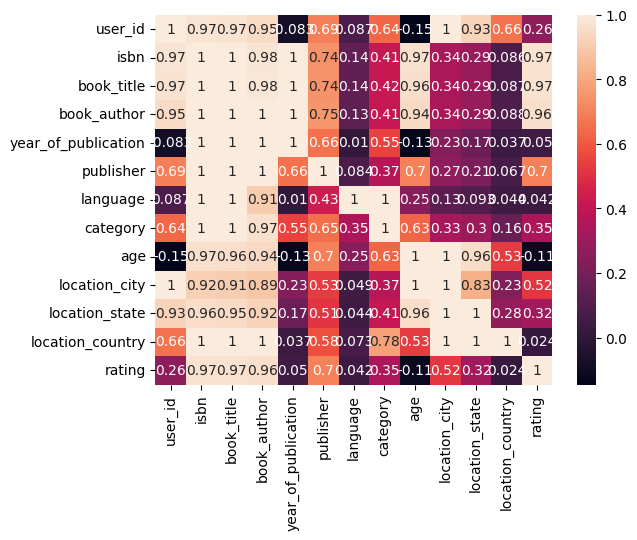

In [24]:
ax = sns.heatmap(
            corr,
            annot=True,
            fmt=
            
        )

## target 과 가장 연관성 있는 feature를 만들어 낼 수 있는가?
